# Model Development for Ethereum Transaction Anomaly Detection

This notebook focuses on developing machine learning models to detect anomalous transactions in Ethereum, with a particular emphasis on identifying triangulation patterns.

## Objectives

1. Load the feature-engineered data from previous notebooks
2. Prepare the data for modeling (train/test split, handling imbalanced data)
3. Develop baseline models for anomaly detection
4. Implement and evaluate more advanced models
5. Tune hyperparameters for optimal performance
6. Compare model performance and select the best model
7. Analyze feature importance and model interpretability
8. Save the final model for deployment

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
from tqdm import tqdm
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    IsolationForest, VotingClassifier
)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

# For handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading the Feature-Engineered Data

We'll start by loading the feature-engineered data from the previous notebooks.

In [2]:
# Define data directories
data_dir = os.path.join('data')
processed_dir = os.path.join(data_dir, 'processed')
models_dir = os.path.join(data_dir, 'models')

# Create models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Load the feature-engineered data
features_path = os.path.join(processed_dir, 'eth_transactions_features.csv')

if os.path.exists(features_path):
    print(f"Loading feature-engineered data from {features_path}")
    df = pd.read_csv(features_path)
else:
    print(f"Feature-engineered data file not found at {features_path}")
    print("Please run the feature engineering notebook first to generate the feature-engineered data.")
    # Create a simple synthetic dataset for demonstration
    print("Creating a synthetic dataset for demonstration...")
    
    # Generate synthetic data
    n_samples = 5000
    n_features = 20
    
    # Generate feature matrix
    X = np.random.randn(n_samples, n_features)
    
    # Generate target variables
    # 10% of transactions are triangulation edges
    is_triangulation = np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1])
    
    # Generate risk scores (higher for triangulation edges)
    risk_scores = np.random.normal(loc=is_triangulation * 10, scale=2, size=n_samples)
    risk_scores = np.maximum(0, risk_scores)  # Ensure non-negative
    
    # Create feature names
    feature_names = [f'feature_{i}' for i in range(n_features)]
    
    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df['is_triangulation_edge'] = is_triangulation
    df['triangulation_risk_score'] = risk_scores

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])

# Fill missing values if any
if missing_values.sum() > 0:
    df = df.fillna(0)
    print("Filled missing values with 0")

# Display basic statistics
print("\nBasic statistics of numerical columns:")
display(df.describe())

Loading feature-engineered data from data/processed/eth_transactions_features.csv

Dataset shape: (100000, 42)

First few rows:


gas_limit  gas_used  gas_price_gwei  transaction_fee  anomaly_flag  \
0      27283     26303              80          2182640             0   
1     429591    108980             101         43388691             0   
2      22711     21990             183          4156113             0   
3     198342    120657              91         18049122             0   
4      22676     21207              86          1950136             0   

   relative_gas_price  gas_price_percentile    log_fee  to_tx_rate_1d  \
0            0.802211              0.401475  14.596046            1.0   
1            1.012792              0.507475  17.585709            1.0   
2            1.835059              0.918050  15.240091            1.0   
3            0.912515              0.457255  16.708608            1.0   
4            0.862377              0.432295  14.483410            1.0   

   from_in_degree  ...  time_night.2  time_night.3  time_morning.2  \
0              39  ...             1             1               0   
1              47  ...             1             1               0   
2              37  ...             1             1               0   
3              45  ...             1             1               0   
4              53  ...             1             1               0   

   time_morning.3  time_afternoon.2  time_afternoon.3  time_evening.2  \
0               0                 0                 0               0   
1               0                 0                 0               0   
2               0                 0                 0               0   
3               0                 0                 0               0   
4               0                 0                 0               0   

   time_evening.3  is_triangulation_edge  triangulation_risk_score  
0               0                      0                 37.000000  
1               0                      0                 27.097895  
2               0                      0                 28.000000  
3               0                      0                 37.000000  
4               0                      1                 44.109397  

[5 rows x 42 columns]


Missing values in each column:
Series([], dtype: int64)

Basic statistics of numerical columns:


gas_limit      gas_used  gas_price_gwei  transaction_fee  \
count  1.000000e+05  1.000000e+05   100000.000000     1.000000e+05   
mean   3.699947e+05  3.162796e+05       99.724340     3.677868e+07   
std    1.347731e+06  1.283186e+06       57.487481     1.557792e+08   
min    2.100000e+04  2.126000e+03        1.000000     2.100300e+04   
25%    2.435900e+04  2.195000e+04       50.000000     1.778260e+06   
50%    2.770800e+04  2.416800e+04      100.000000     3.536032e+06   
75%    1.721062e+05  6.258125e+04      150.000000     1.045317e+07   
max    7.999021e+06  7.983127e+06      199.000000     1.580035e+09   

        anomaly_flag  relative_gas_price  gas_price_percentile        log_fee  \
count  100000.000000       100000.000000         100000.000000  100000.000000   
mean        0.079480            1.000000              0.500005      15.312813   
std         0.270488            0.576464              0.288673       1.718539   
min         0.000000            0.010028              0.002505       9.952468   
25%         0.000000            0.501382              0.250475      14.391146   
50%         0.000000            1.002764              0.502120      15.078516   
75%         0.000000            1.504146              0.751535      16.162416   
max         1.000000            1.995501              0.997570      21.180713   

       to_tx_rate_1d  from_in_degree  ...   time_night.2   time_night.3  \
count  100000.000000   100000.000000  ...  100000.000000  100000.000000   
mean       15.527400       42.149290  ...       0.290870       0.290870   
std         6.175762        6.577724  ...       0.454166       0.454166   
min         1.000000       22.000000  ...       0.000000       0.000000   
25%        11.000000       38.000000  ...       0.000000       0.000000   
50%        20.000000       42.000000  ...       0.000000       0.000000   
75%        20.000000       47.000000  ...       1.000000       1.000000   
max        20.000000       66.000000  ...       1.000000       1.000000   

       time_morning.2  time_morning.3  time_afternoon.2  time_afternoon.3  \
count   100000.000000   100000.000000     100000.000000     100000.000000   
mean         0.249200        0.249200          0.250370          0.250370   
std          0.432552        0.432552          0.433228          0.433228   
min          0.000000        0.000000          0.000000          0.000000   
25%          0.000000        0.000000          0.000000          0.000000   
50%          0.000000        0.000000          0.000000          0.000000   
75%          0.000000        0.000000          1.000000          1.000000   
max          1.000000        1.000000          1.000000          1.000000   

       time_evening.2  time_evening.3  is_triangulation_edge  \
count   100000.000000   100000.000000          100000.000000   
mean         0.209560        0.209560               0.549920   
std          0.406997        0.406997               0.497504   
min          0.000000        0.000000               0.000000   
25%          0.000000        0.000000               0.000000   
50%          0.000000        0.000000               1.000000   
75%          0.000000        0.000000               1.000000   
max          1.000000        1.000000               1.000000   

       triangulation_risk_score  
count             100000.000000  
mean                  39.221331  
std                    7.886960  
min                   12.500000  
25%                   33.607272  
50%                   39.000000  
75%                   44.500000  
max                   84.718333  

[8 rows x 41 columns]

## 2. Preparing the Data for Modeling

Now let's prepare the data for modeling, including:

1. Defining the target variables
2. Splitting the data into training and testing sets
3. Handling imbalanced data
4. Scaling the features

In [3]:
# 2.1 Define the target variables and prepare features
# First, identify categorical columns in the dataset
categorical_columns = []
numeric_columns = []

for column in df.columns:
    # Skip target variables
    if column in ['is_triangulation_edge', 'triangulation_risk_score']:
        continue
    
    # Check if column contains non-numeric data
    if df[column].dtype == 'object' or df[column].dtype.name == 'category':
        categorical_columns.append(column)
    else:
        numeric_columns.append(column)

print(f"Identified {len(categorical_columns)} categorical columns: {categorical_columns}")
print(f"Identified {len(numeric_columns)} numeric columns")

# Handle categorical columns with one-hot encoding
X = df.drop(['is_triangulation_edge', 'triangulation_risk_score'], axis=1)
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

print(f"Original feature shape: {X.shape}")
print(f"Encoded feature shape: {X_encoded.shape}")

# Continue with the target variables
y_binary = df['is_triangulation_edge']
y_risk = df['triangulation_risk_score']

# Create a binary target for high-risk transactions
risk_threshold = df['triangulation_risk_score'].quantile(0.9)  # Top 10% as high risk
y_high_risk = (df['triangulation_risk_score'] >= risk_threshold).astype(int)

print(f"\nFeature matrix shape: {X_encoded.shape}")
print(f"Binary target shape: {y_binary.shape}")
print(f"Risk score target shape: {y_risk.shape}")
print(f"High-risk binary target shape: {y_high_risk.shape}")
print(f"Percentage of high-risk transactions: {y_high_risk.mean() * 100:.2f}%")

# 2.3 Split the data into training and testing sets
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X_encoded, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

_, _, y_train_risk, y_test_risk = train_test_split(
    X_encoded, y_risk, test_size=0.3, random_state=42
)

_, _, y_train_high_risk, y_test_high_risk = train_test_split(
    X_encoded, y_risk, test_size=0.3, random_state=42, stratify=y_high_risk
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Percentage of triangulation edges in training set: {y_train_binary.mean() * 100:.2f}%")
print(f"Percentage of triangulation edges in testing set: {y_test_binary.mean() * 100:.2f}%")

# 2.4 Scale the features (now only numerical ones will be present)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 2.5 Handle imbalanced data using SMOTE
print("\nHandling imbalanced data using SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_binary_resampled = smote.fit_resample(X_train_scaled, y_train_binary)

print(f"Original training set shape: {X_train_scaled.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Percentage of triangulation edges in original training set: {y_train_binary.mean() * 100:.2f}%")
print(f"Percentage of triangulation edges in resampled training set: {y_train_binary_resampled.mean() * 100:.2f}%")

Identified 1 categorical columns: ['time_of_day']
Identified 39 numeric columns
Original feature shape: (100000, 40)
Encoded feature shape: (100000, 42)

Feature matrix shape: (100000, 42)
Binary target shape: (100000,)
Risk score target shape: (100000,)
High-risk binary target shape: (100000,)
Percentage of high-risk transactions: 10.00%

Training set shape: (70000, 42)
Testing set shape: (30000, 42)
Percentage of triangulation edges in training set: 54.99%
Percentage of triangulation edges in testing set: 54.99%

Handling imbalanced data using SMOTE...
Original training set shape: (70000, 42)
Resampled training set shape: (76988, 42)
Percentage of triangulation edges in original training set: 54.99%
Percentage of triangulation edges in resampled training set: 50.00%


## 3. Developing Baseline Models

Let's start by developing some baseline models for anomaly detection.

Developing baseline models...

--- Logistic Regression ---

Logistic Regression Results:
Accuracy: 0.5998
Precision: 0.6536
Recall: 0.5793
F1 Score: 0.6142
ROC AUC: 0.6407
Average Precision: 0.6774
Training Time: 0.2426 seconds
Prediction Time: 0.0042 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58     13502
           1       0.65      0.58      0.61     16498

    accuracy                           0.60     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.61      0.60      0.60     30000



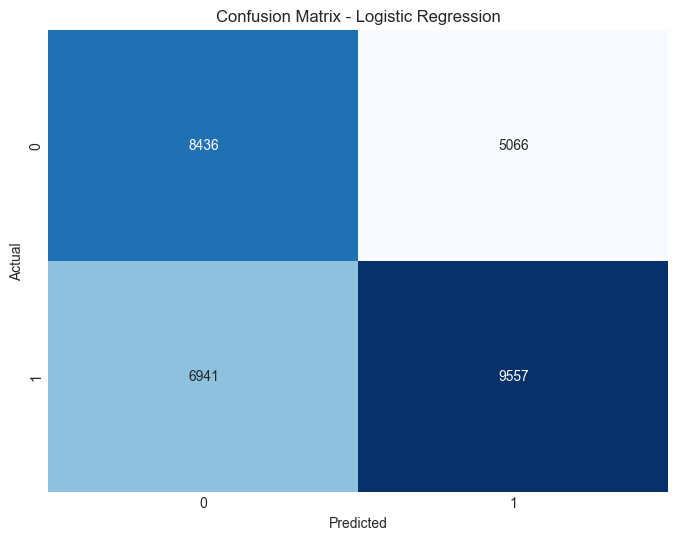

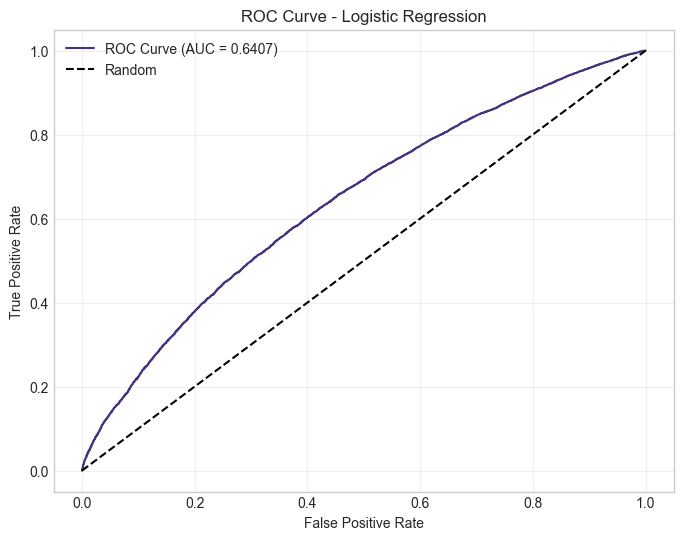

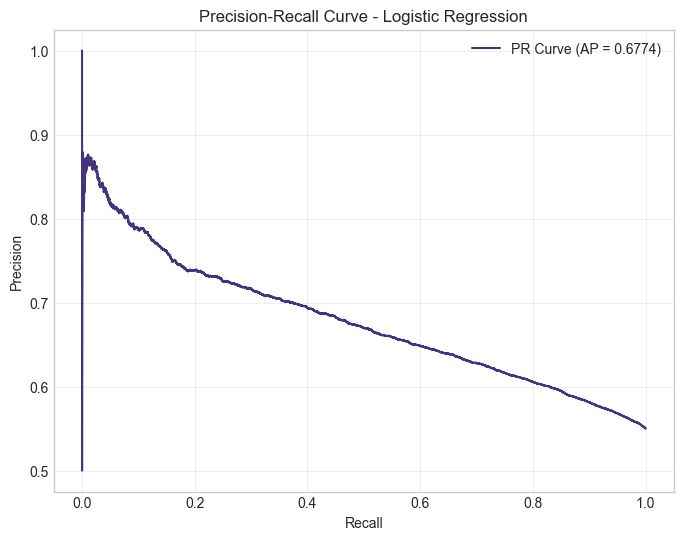


--- Random Forest ---

Random Forest Results:
Accuracy: 0.5826
Precision: 0.6193
Recall: 0.6254
F1 Score: 0.6224
ROC AUC: 0.6096
Average Precision: 0.6462
Training Time: 14.2275 seconds
Prediction Time: 0.5198 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.53      0.53     13502
           1       0.62      0.63      0.62     16498

    accuracy                           0.58     30000
   macro avg       0.58      0.58      0.58     30000
weighted avg       0.58      0.58      0.58     30000



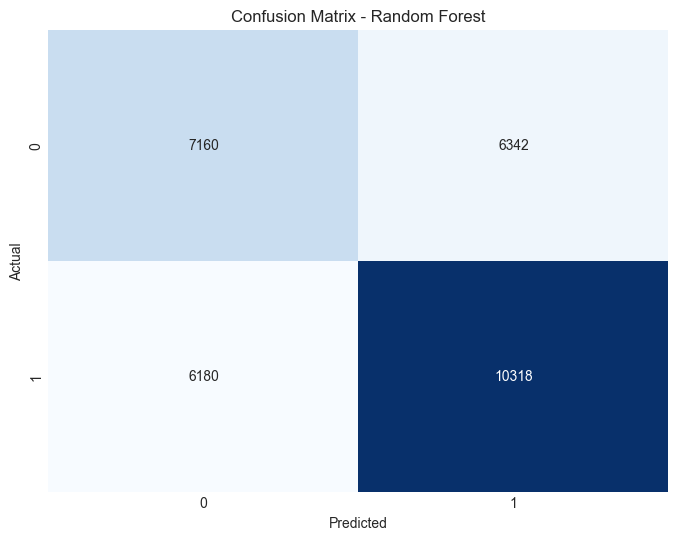

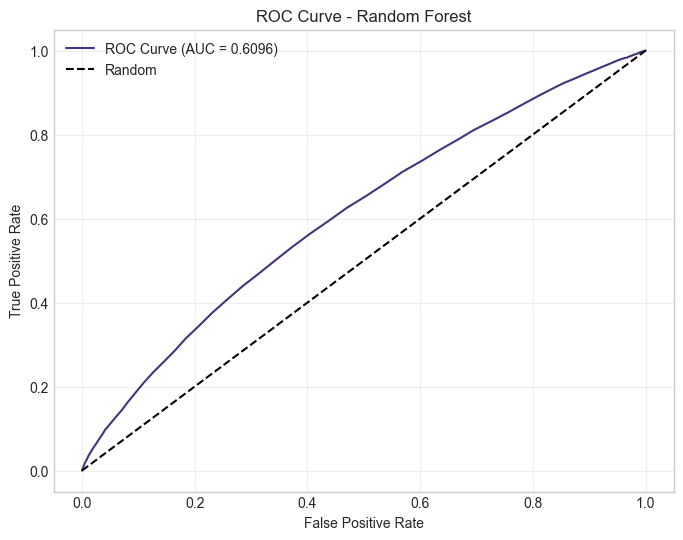

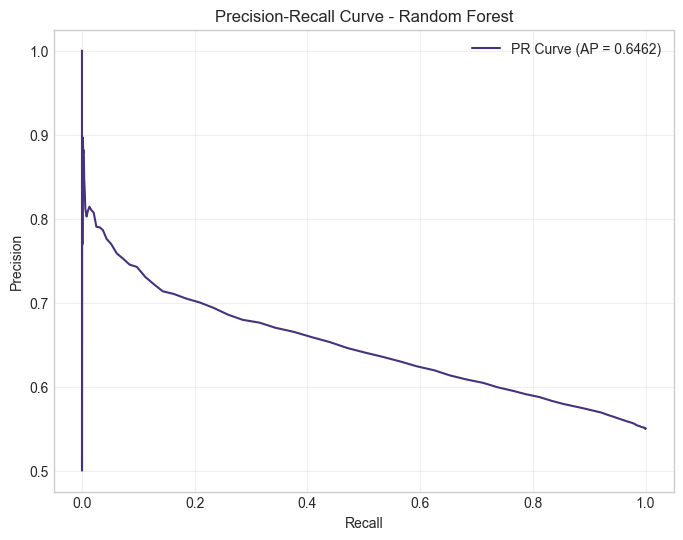


--- Gradient Boosting ---

Gradient Boosting Results:
Accuracy: 0.5996
Precision: 0.6403
Recall: 0.6202
F1 Score: 0.6301
ROC AUC: 0.6374
Average Precision: 0.6770
Training Time: 20.9649 seconds
Prediction Time: 0.0279 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56     13502
           1       0.64      0.62      0.63     16498

    accuracy                           0.60     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.60      0.60      0.60     30000



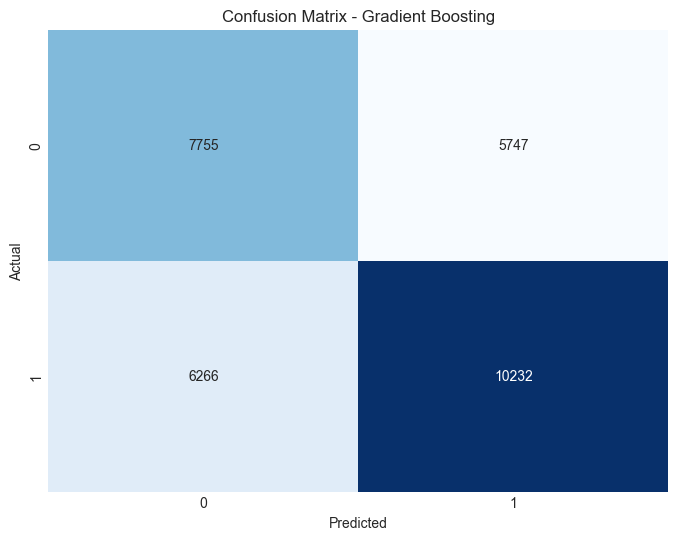

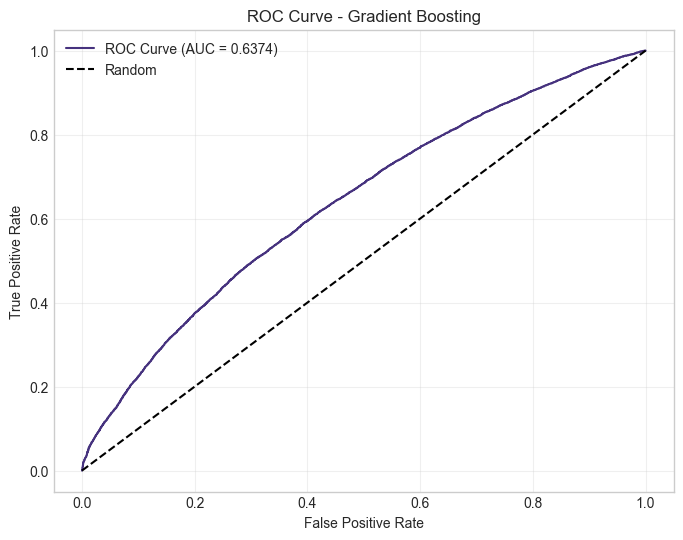

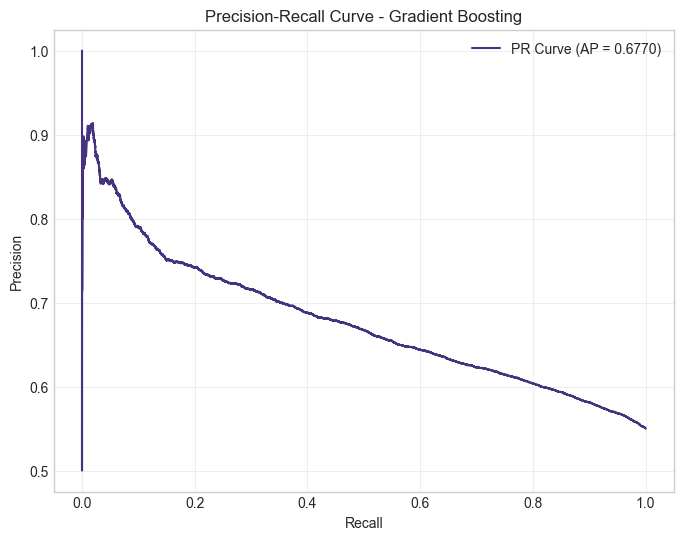


Baseline Model Comparison:


Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0  Logistic Regression  0.599767   0.653559  0.579282  0.614183  0.640732   
1        Random Forest  0.582600   0.619328  0.625409  0.622354  0.609558   
2    Gradient Boosting  0.599567   0.640340  0.620196  0.630107  0.637442   

   Avg Precision  Training Time (s)  Prediction Time (s)  
0       0.677418           0.242578             0.004174  
1       0.646230          14.227512             0.519774  
2       0.677038          20.964870             0.027948

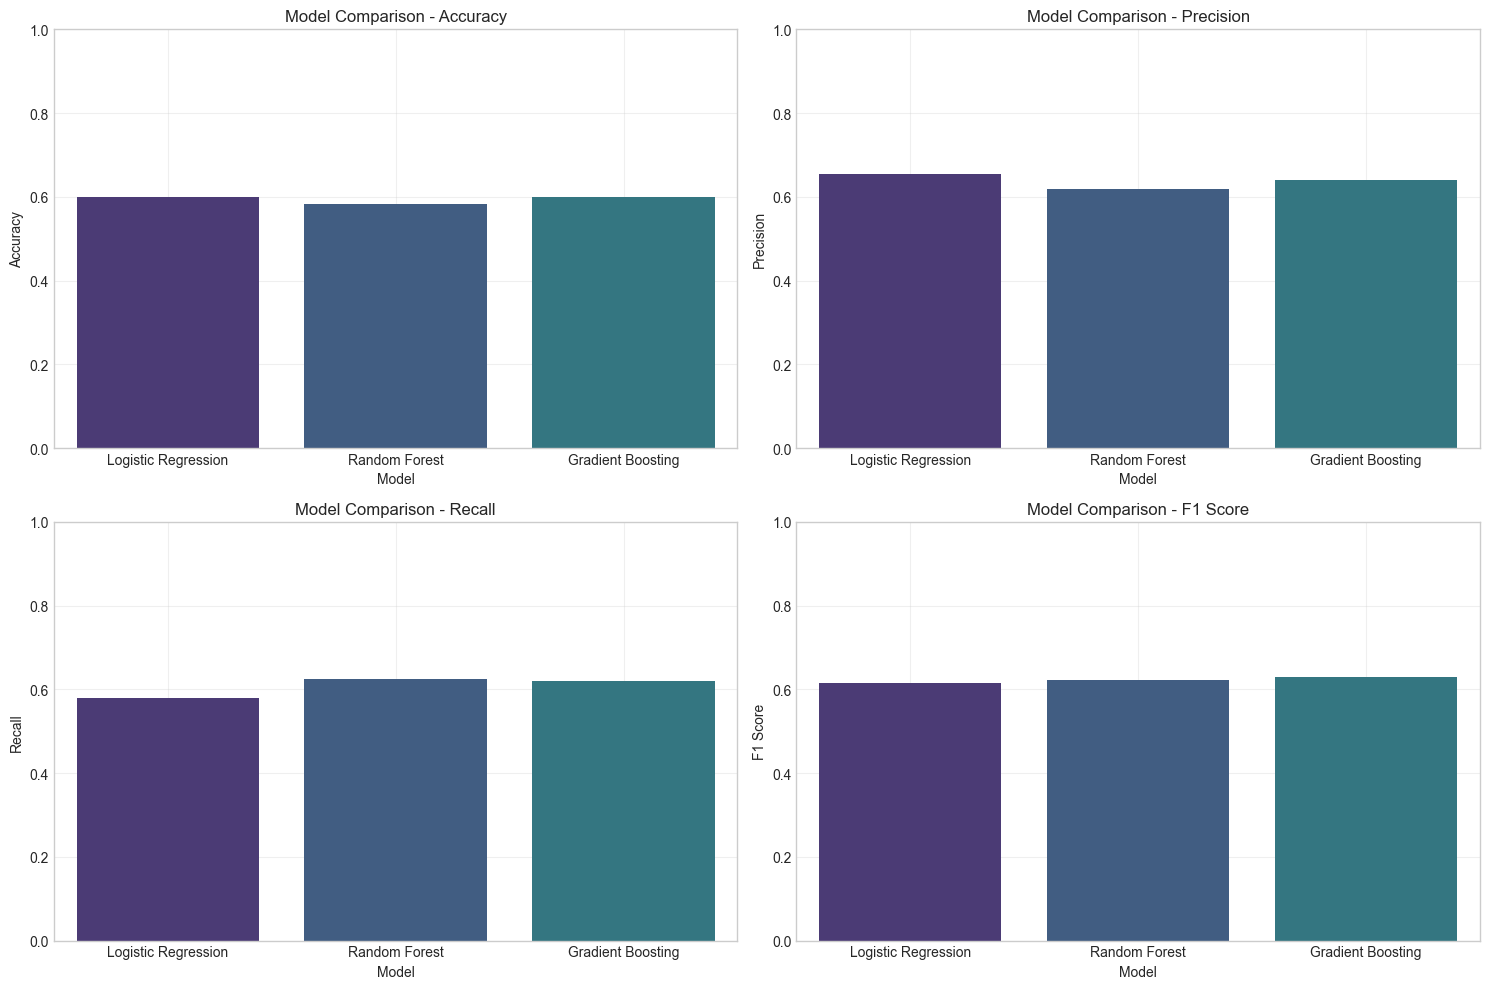

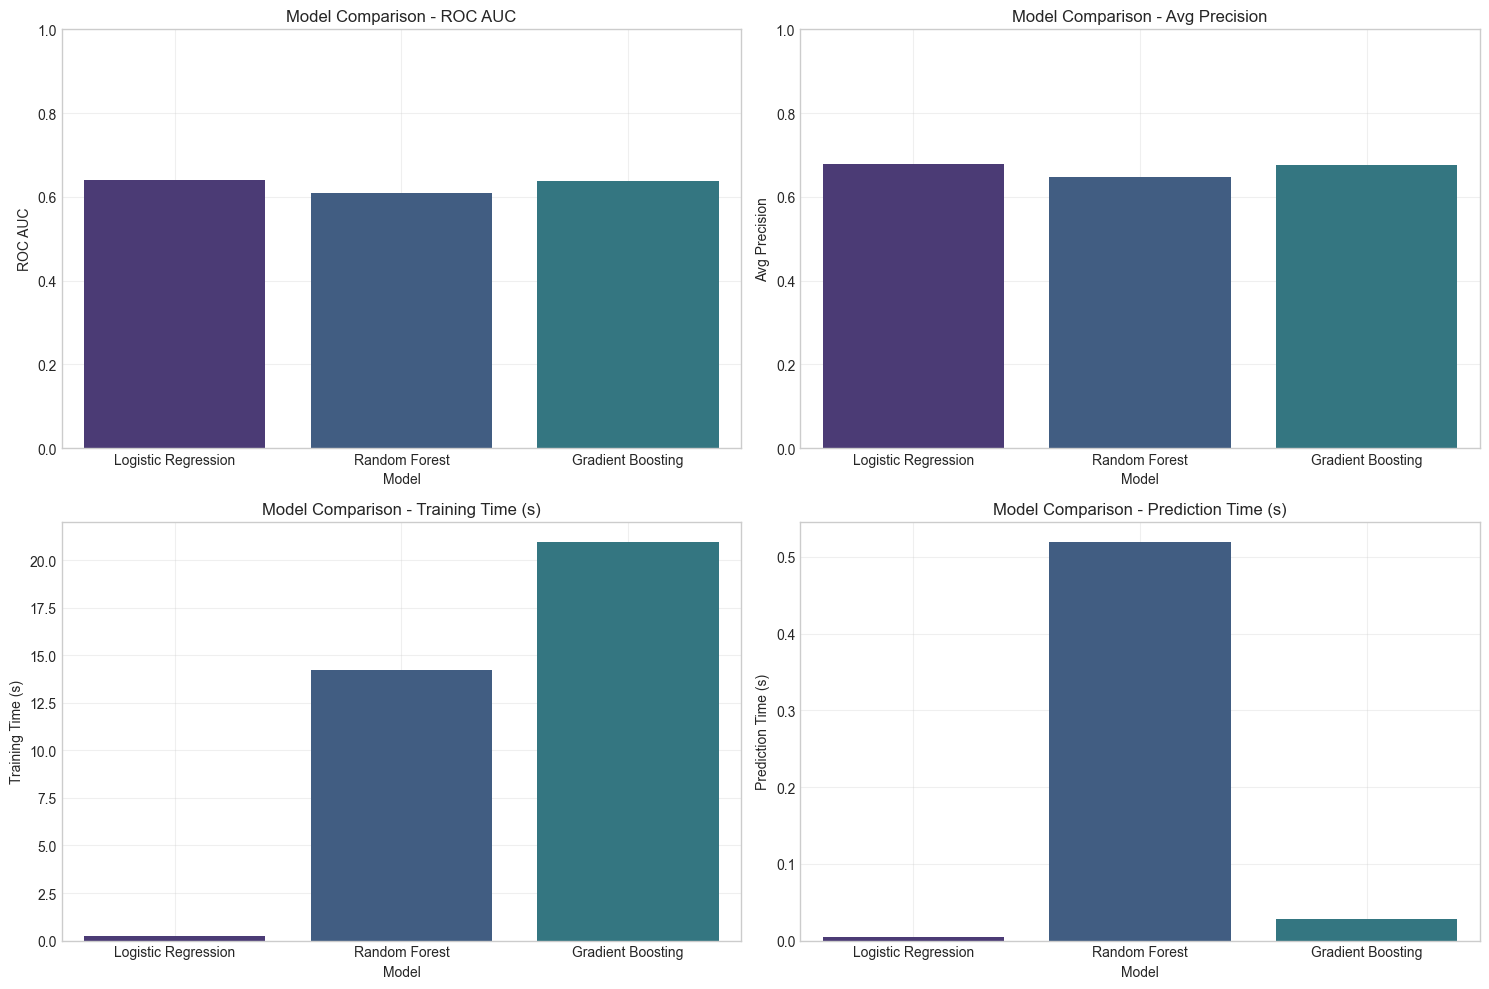

In [8]:
# 3.1 Define a function to evaluate classification models
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Train and evaluate a classification model.
    
    Parameters:
    -----------
    model : sklearn model
        The classification model to evaluate
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    X_test : array-like
        Testing features
    y_test : array-like
        Testing target
    model_name : str
        Name of the model for display
        
    Returns:
    --------
    results : dict
        Dictionary containing evaluation metrics
    """
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Get probability predictions if available
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    avg_precision = average_precision_score(y_test, y_prob)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Prediction Time: {predict_time:.4f} seconds")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall_curve, precision_curve, label=f'PR Curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Return results
    results = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'train_time': train_time,
        'predict_time': predict_time,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred)
    }
    
    return results

# 3.2 Develop baseline models
print("Developing baseline models...")

# Logistic Regression
print("\n--- Logistic Regression ---")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_results = evaluate_classifier(
    lr, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "Logistic Regression"
)

# Random Forest
print("\n--- Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_classifier(
    rf, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "Random Forest"
)

# Gradient Boosting
print("\n--- Gradient Boosting ---")
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_results = evaluate_classifier(
    gb, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "Gradient Boosting"
)

# 3.3 Compare baseline models
baseline_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [lr_results['accuracy'], rf_results['accuracy'], gb_results['accuracy']],
    'Precision': [lr_results['precision'], rf_results['precision'], gb_results['precision']],
    'Recall': [lr_results['recall'], rf_results['recall'], gb_results['recall']],
    'F1 Score': [lr_results['f1'], rf_results['f1'], gb_results['f1']],
    'ROC AUC': [lr_results['roc_auc'], rf_results['roc_auc'], gb_results['roc_auc']],
    'Avg Precision': [lr_results['avg_precision'], rf_results['avg_precision'], gb_results['avg_precision']],
    'Training Time (s)': [lr_results['train_time'], rf_results['train_time'], gb_results['train_time']],
    'Prediction Time (s)': [lr_results['predict_time'], rf_results['predict_time'], gb_results['predict_time']]
})

print("\nBaseline Model Comparison:")
display(baseline_results)

# Visualize model comparison
plt.figure(figsize=(15, 10))

# Accuracy, Precision, Recall, F1
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=baseline_results)
    plt.title(f'Model Comparison - {metric}')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ROC AUC, Avg Precision, Training Time, Prediction Time
plt.figure(figsize=(15, 10))

metrics = ['ROC AUC', 'Avg Precision', 'Training Time (s)', 'Prediction Time (s)']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=baseline_results)
    plt.title(f'Model Comparison - {metric}')
    if metric in ['ROC AUC', 'Avg Precision']:
        plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Implementing Advanced Models

Now let's implement more advanced models for anomaly detection.


--- Isolation Forest (Unsupervised) ---
Isolation Forest Results (Unsupervised):
Accuracy: 0.4755
Precision: 0.6315
Recall: 0.1110
F1 Score: 0.1889


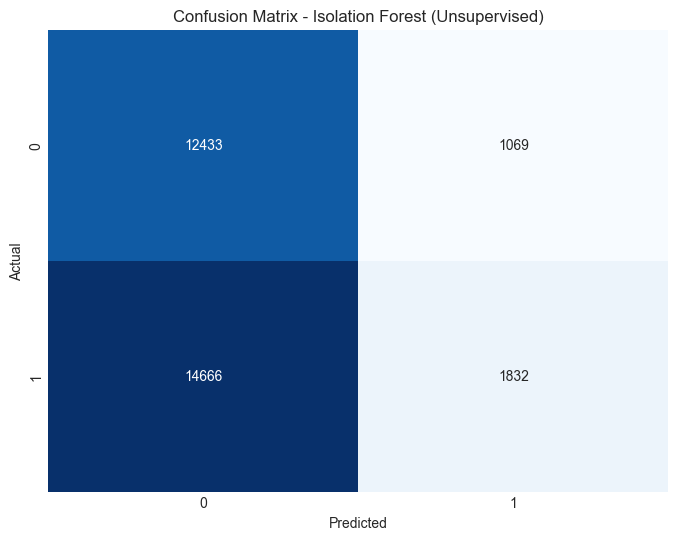


--- XGBoost ---

XGBoost Results:
Accuracy: 0.5919
Precision: 0.6205
Recall: 0.6639
F1 Score: 0.6415
ROC AUC: 0.6215
Average Precision: 0.6610
Training Time: 2.4091 seconds
Prediction Time: 0.0116 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.50      0.53     13502
           1       0.62      0.66      0.64     16498

    accuracy                           0.59     30000
   macro avg       0.59      0.58      0.58     30000
weighted avg       0.59      0.59      0.59     30000



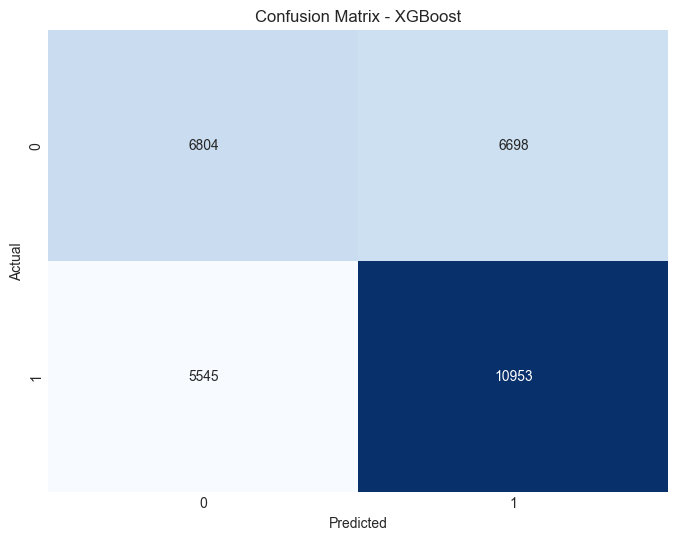

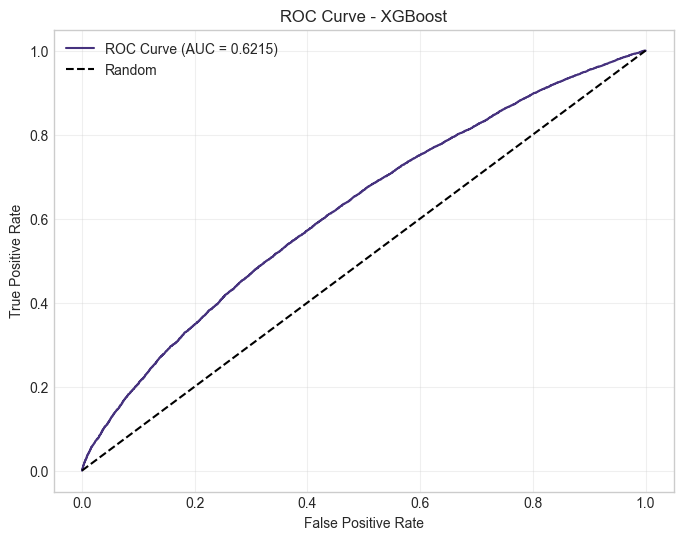

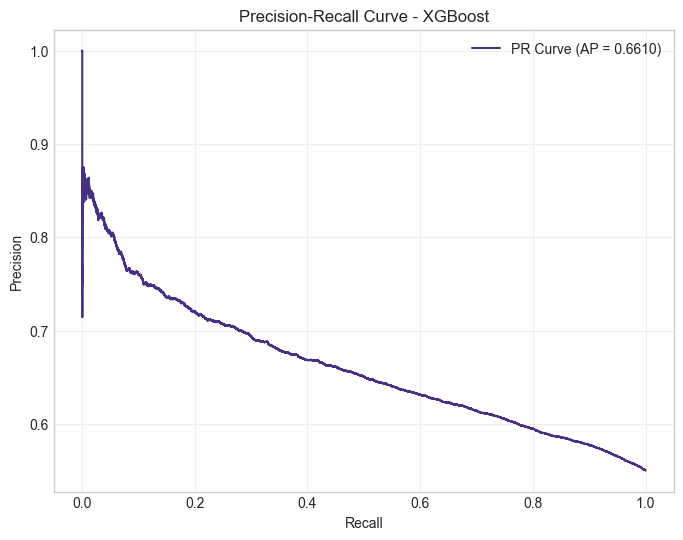


--- LightGBM ---
[LightGBM] [Info] Number of positive: 38494, number of negative: 38494
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4996
[LightGBM] [Info] Number of data points in the train set: 76988, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM Results:
Accuracy: 0.6007
Precision: 0.6288
Recall: 0.6686
F1 Score: 0.6481
ROC AUC: 0.6338
Average Precision: 0.6722
Training Time: 0.5087 seconds
Prediction Time: 0.0236 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54     13502
           1       0.63      0.67      0.65     16498

    accuracy                           0.60     30000
   macro avg       0.59      0.59      0.59    

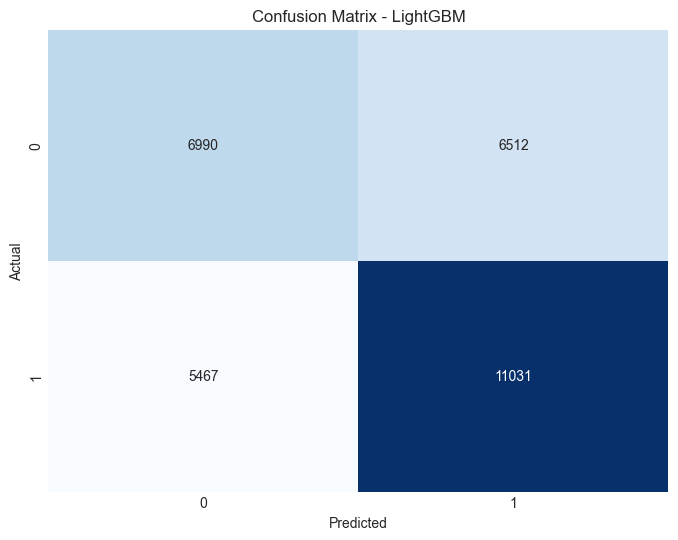

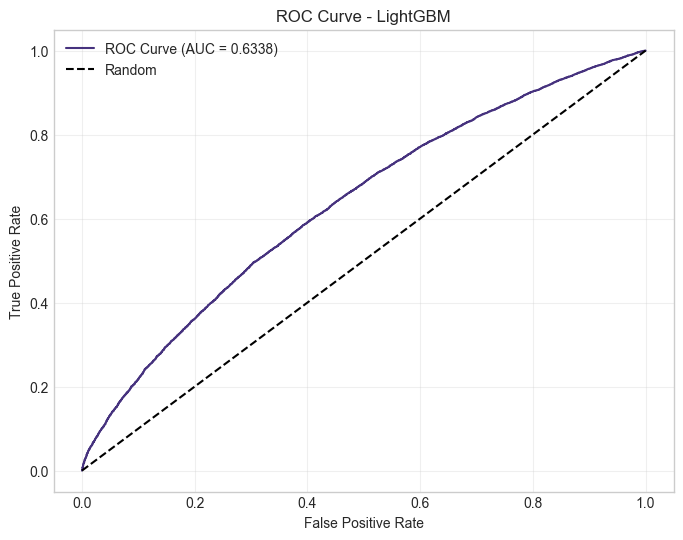

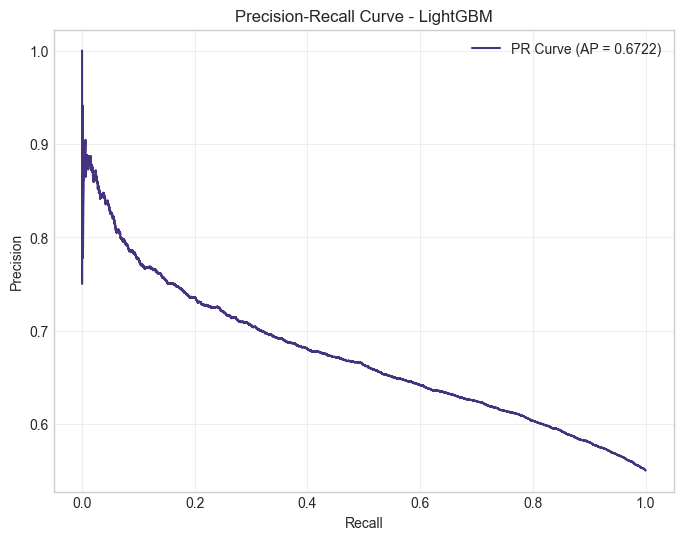


--- Linear Support Vector Machine ---

LinearSVC Results:
Accuracy: 0.5990
Precision: 0.6538
Recall: 0.5755
F1 Score: 0.6122
ROC AUC: 0.6016
Average Precision: 0.6097
Training Time: 15.2946 seconds
Prediction Time: 0.0008 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.63      0.58     13502
           1       0.65      0.58      0.61     16498

    accuracy                           0.60     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.61      0.60      0.60     30000



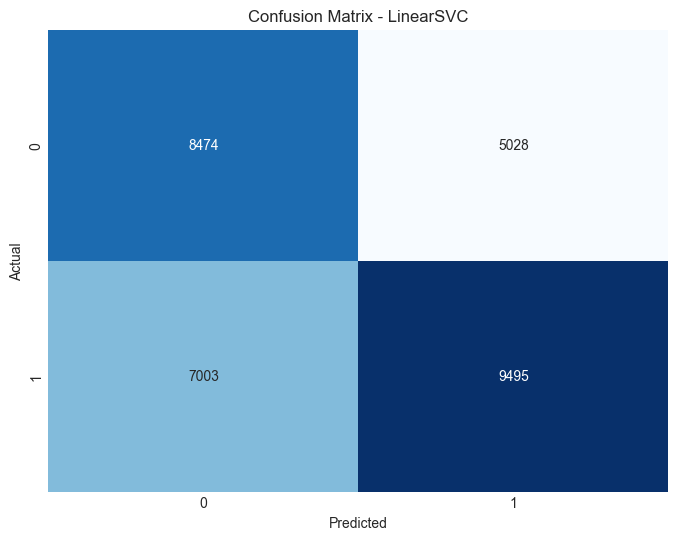

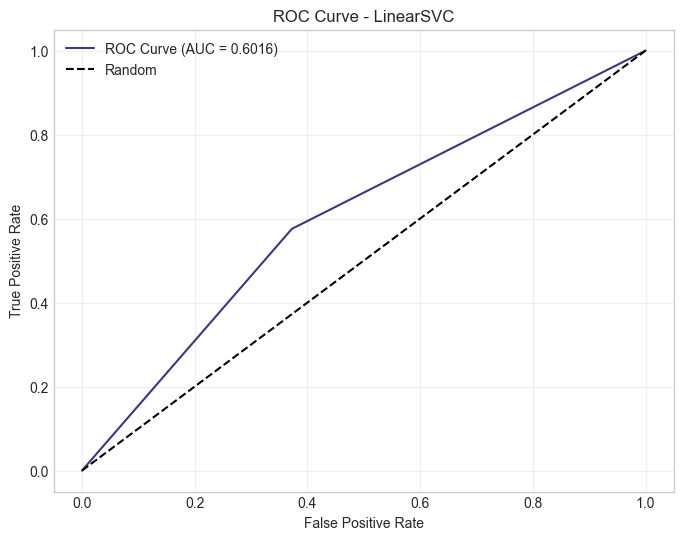

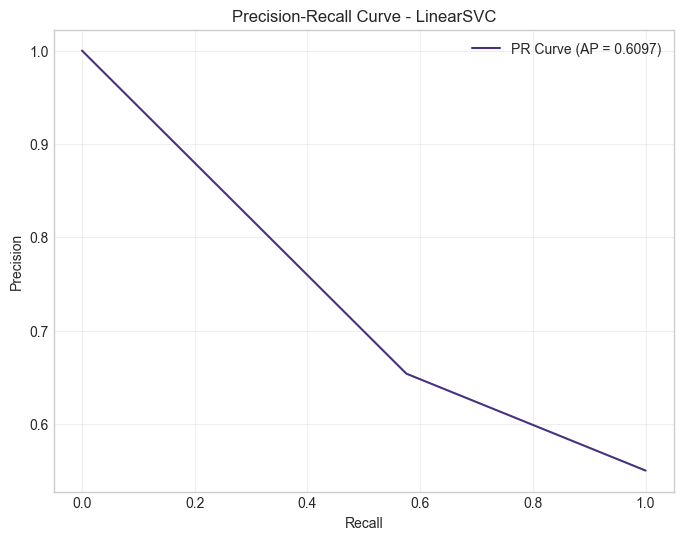


--- Neural Network ---

Neural Network Results:
Accuracy: 0.5551
Precision: 0.6093
Recall: 0.5327
F1 Score: 0.5684
ROC AUC: 0.5800
Average Precision: 0.6217
Training Time: 96.3531 seconds
Prediction Time: 0.0479 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.54     13502
           1       0.61      0.53      0.57     16498

    accuracy                           0.56     30000
   macro avg       0.56      0.56      0.55     30000
weighted avg       0.56      0.56      0.56     30000



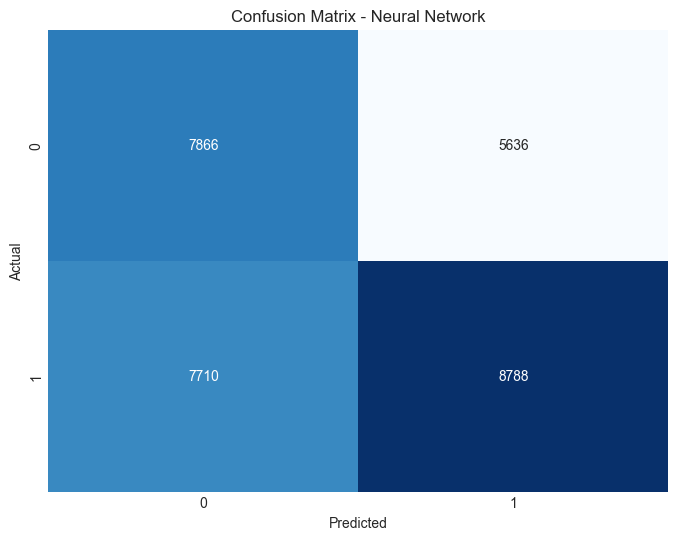

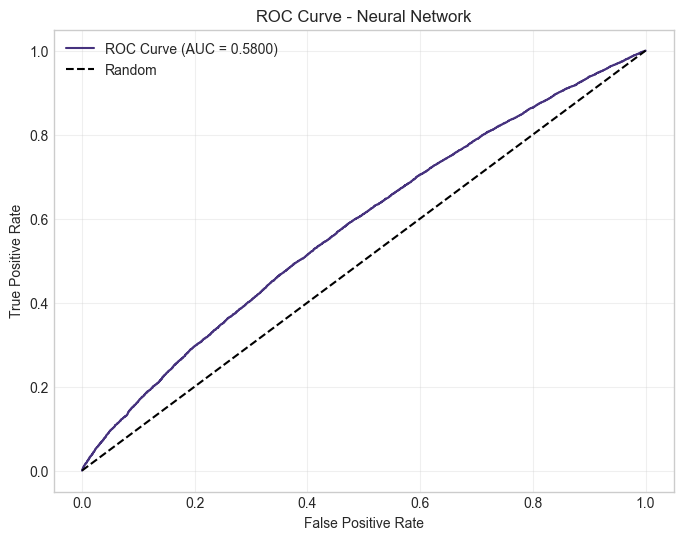

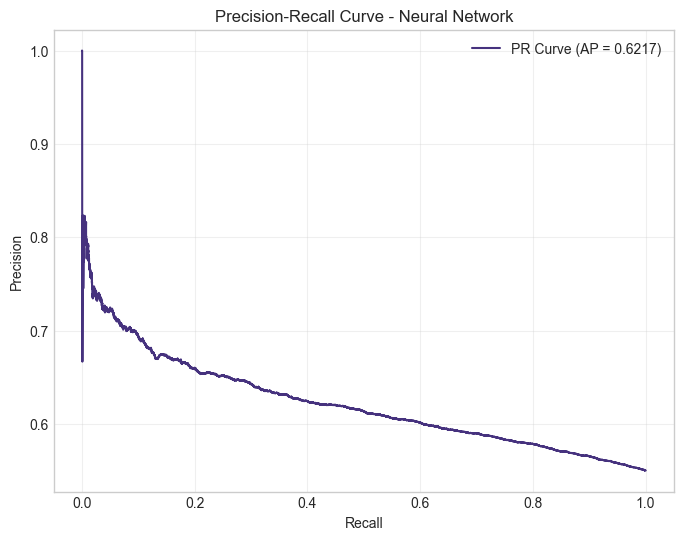


--- Voting Ensemble ---

Voting Ensemble Results:
Accuracy: 0.6002
Precision: 0.6369
Recall: 0.6349
F1 Score: 0.6359
ROC AUC: 0.6355
Average Precision: 0.6748
Training Time: 39.3096 seconds
Prediction Time: 0.5893 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56     13502
           1       0.64      0.63      0.64     16498

    accuracy                           0.60     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.60      0.60      0.60     30000



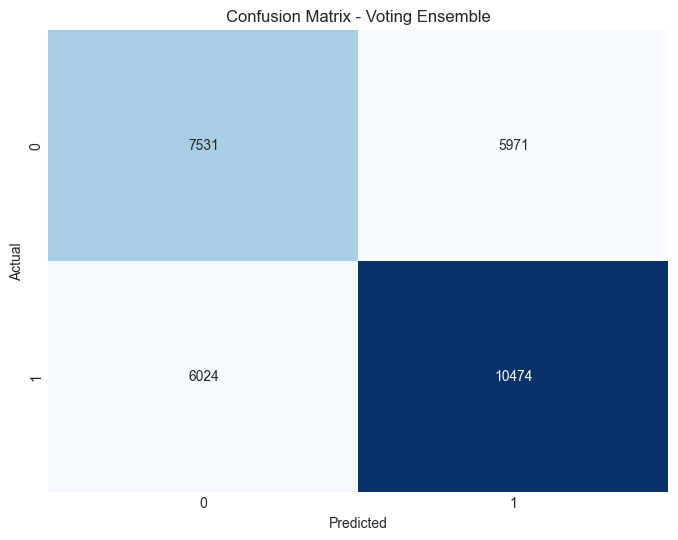

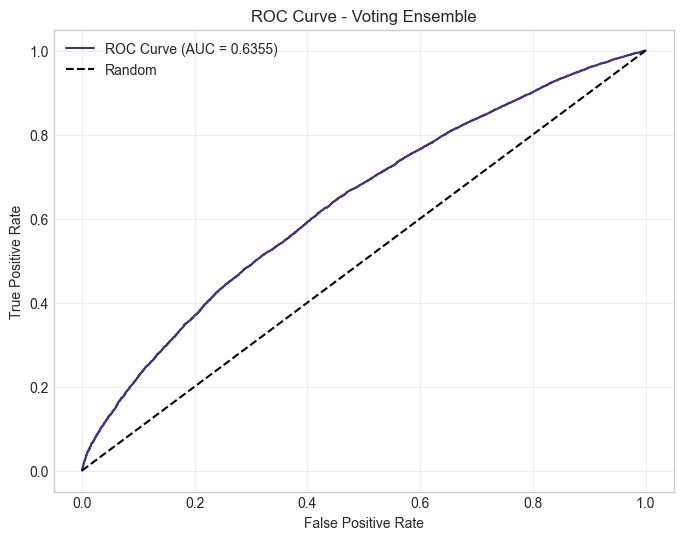

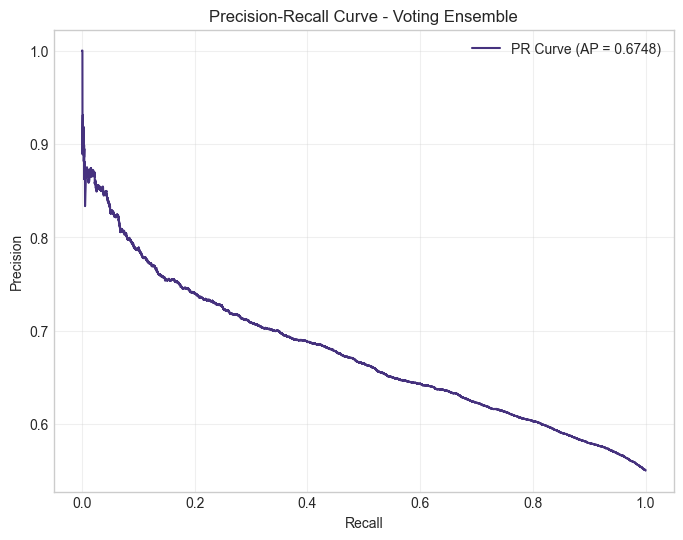


All Model Comparison:


Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0  Logistic Regression  0.599767   0.653559  0.579282  0.614183  0.640732   
1        Random Forest  0.582600   0.619328  0.625409  0.622354  0.609558   
2    Gradient Boosting  0.599567   0.640340  0.620196  0.630107  0.637442   
3     Isolation Forest  0.475500   0.631506  0.111044  0.188876       NaN   
4              XGBoost  0.591900   0.620531  0.663899  0.641483  0.621529   
5             LightGBM  0.600700   0.628798  0.668627  0.648101  0.633832   
6                  SVM  0.598967   0.653791  0.575524  0.612166  0.601568   
7       Neural Network  0.555133   0.609262  0.532671  0.568398  0.580033   
8      Voting Ensemble  0.600167   0.636911  0.634865  0.635886  0.635537   

   Avg Precision  
0       0.677418  
1       0.646230  
2       0.677038  
3            NaN  
4       0.661025  
5       0.672190  
6       0.609706  
7       0.621741  
8       0.674812

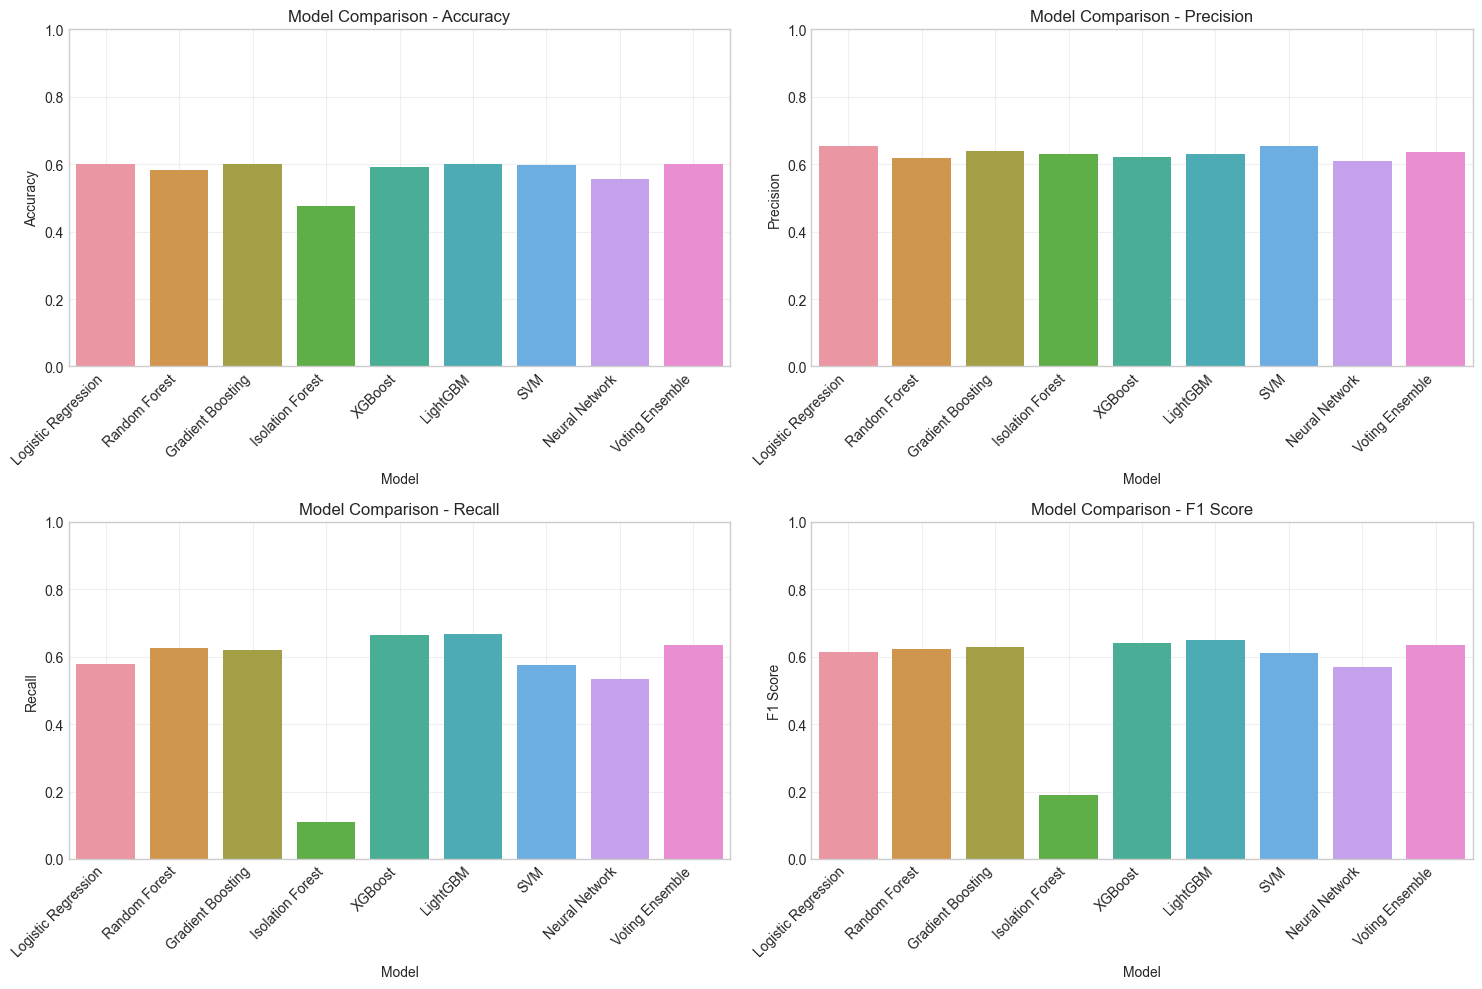

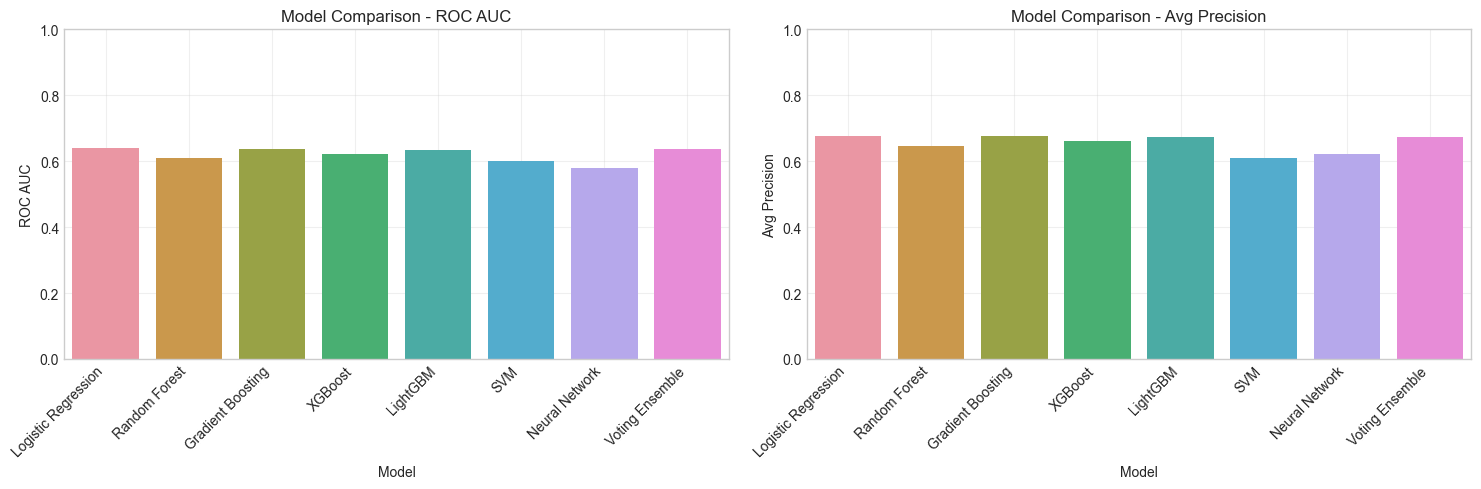

In [11]:
# 4.1 Isolation Forest for unsupervised anomaly detection
print("\n--- Isolation Forest (Unsupervised) ---")
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X_train_scaled)

# Predict anomalies (-1 for anomalies, 1 for normal)
y_pred_iso = iso_forest.predict(X_test_scaled)
# Convert to binary (1 for anomalies, 0 for normal)
y_pred_iso = (y_pred_iso == -1).astype(int)

# Calculate metrics
accuracy_iso = accuracy_score(y_test_binary, y_pred_iso)
precision_iso = precision_score(y_test_binary, y_pred_iso)
recall_iso = recall_score(y_test_binary, y_pred_iso)
f1_iso = f1_score(y_test_binary, y_pred_iso)

print(f"Isolation Forest Results (Unsupervised):")
print(f"Accuracy: {accuracy_iso:.4f}")
print(f"Precision: {precision_iso:.4f}")
print(f"Recall: {recall_iso:.4f}")
print(f"F1 Score: {f1_iso:.4f}")

# Confusion matrix
cm_iso = confusion_matrix(y_test_binary, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Isolation Forest (Unsupervised)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4.2 XGBoost
print("\n--- XGBoost ---")
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb_results = evaluate_classifier(
    xgb, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "XGBoost"
)

# 4.3 LightGBM
print("\n--- LightGBM ---")
lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_results = evaluate_classifier(
    lgbm, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "LightGBM"
)


# 4.4 Linear Vector Machine
print("\n--- Linear Support Vector Machine ---")
linear_svc = LinearSVC(random_state=42)  # Sin 'dual', usa el valor por defecto (True)
linear_svc_results = evaluate_classifier(
    linear_svc, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "LinearSVC"
)


# 4.5 Neural Network
print("\n--- Neural Network ---")
nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
nn_results = evaluate_classifier(
    nn, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "Neural Network"
)

# 4.6 Ensemble of models (Voting Classifier)
print("\n--- Voting Ensemble ---")
voting = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft'
)
voting_results = evaluate_classifier(
    voting, X_train_resampled, y_train_binary_resampled, 
    X_test_scaled, y_test_binary, "Voting Ensemble"
)

# 4.7 Compare all models
all_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 
              'Isolation Forest', 'XGBoost', 'LightGBM', 'SVM', 
              'Neural Network', 'Voting Ensemble'],
    'Accuracy': [lr_results['accuracy'], rf_results['accuracy'], gb_results['accuracy'],
                accuracy_iso, xgb_results['accuracy'], lgbm_results['accuracy'],
                linear_svc_results['accuracy'], nn_results['accuracy'], voting_results['accuracy']],
    'Precision': [lr_results['precision'], rf_results['precision'], gb_results['precision'],
                 precision_iso, xgb_results['precision'], lgbm_results['precision'],
                 linear_svc_results['precision'], nn_results['precision'], voting_results['precision']],
    'Recall': [lr_results['recall'], rf_results['recall'], gb_results['recall'],
              recall_iso, xgb_results['recall'], lgbm_results['recall'],
              linear_svc_results['recall'], nn_results['recall'], voting_results['recall']],
    'F1 Score': [lr_results['f1'], rf_results['f1'], gb_results['f1'],
                f1_iso, xgb_results['f1'], lgbm_results['f1'],
                linear_svc_results['f1'], nn_results['f1'], voting_results['f1']],
    'ROC AUC': [lr_results['roc_auc'], rf_results['roc_auc'], gb_results['roc_auc'],
               np.nan, xgb_results['roc_auc'], lgbm_results['roc_auc'],
               linear_svc_results['roc_auc'], nn_results['roc_auc'], voting_results['roc_auc']],
    'Avg Precision': [lr_results['avg_precision'], rf_results['avg_precision'], gb_results['avg_precision'],
                     np.nan, xgb_results['avg_precision'], lgbm_results['avg_precision'],
                     linear_svc_results['avg_precision'], nn_results['avg_precision'], voting_results['avg_precision']]
})

print("\nAll Model Comparison:")
display(all_results)

# Visualize model comparison
plt.figure(figsize=(15, 10))

# Accuracy, Precision, Recall, F1
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=all_results)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ROC AUC, Avg Precision
plt.figure(figsize=(15, 5))

metrics = ['ROC AUC', 'Avg Precision']
for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    # Filter out NaN values
    metric_data = all_results[['Model', metric]].dropna()
    sns.barplot(x='Model', y=metric, data=metric_data)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

Let's tune the hyperparameters of the best-performing models to further improve their performance.

Top 3 models by F1 Score:


Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
5         LightGBM  0.600700   0.628798  0.668627  0.648101  0.633832   
4          XGBoost  0.591900   0.620531  0.663899  0.641483  0.621529   
8  Voting Ensemble  0.600167   0.636911  0.634865  0.635886  0.635537   

   Avg Precision  
5       0.672190  
4       0.661025  
8       0.674812


Performing hyperparameter tuning for: LightGBM
Performing grid search for LightGBM...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795
[LightGBM] [Info] Number of positive: 30796, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30796
[LightGBM] [Info] Number of positive: 30795, number of negative: 30796
[LightGBM] [Info] Number of positive: 30796, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795
[LightGBM] [Info] Number of positive: 30795, number of negative: 30795

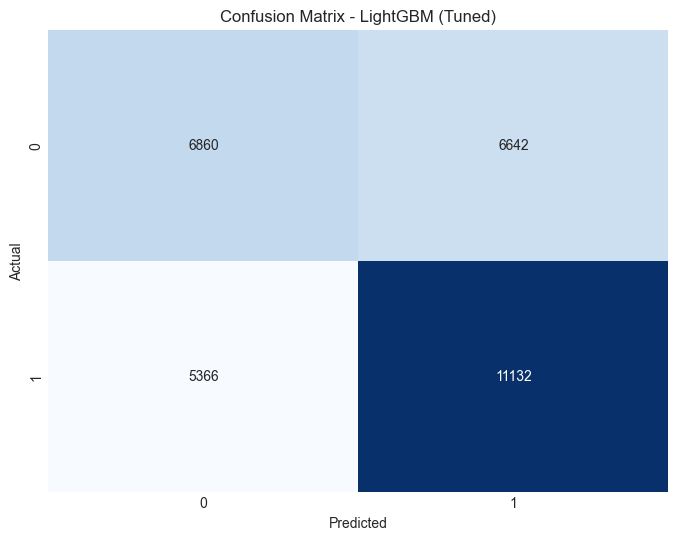

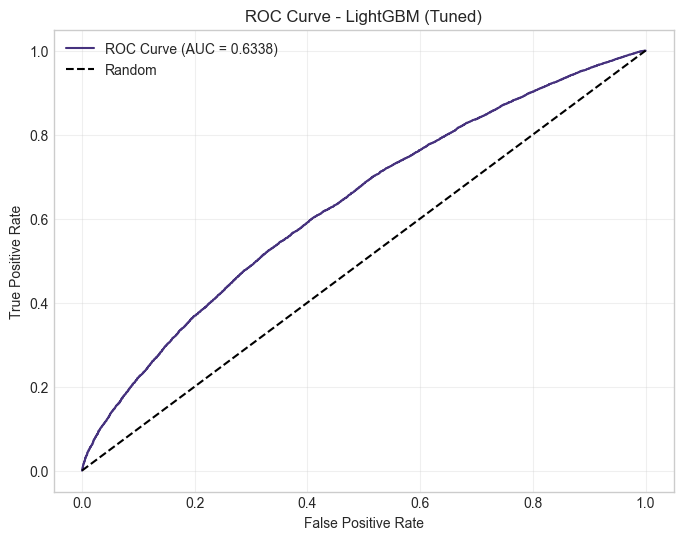

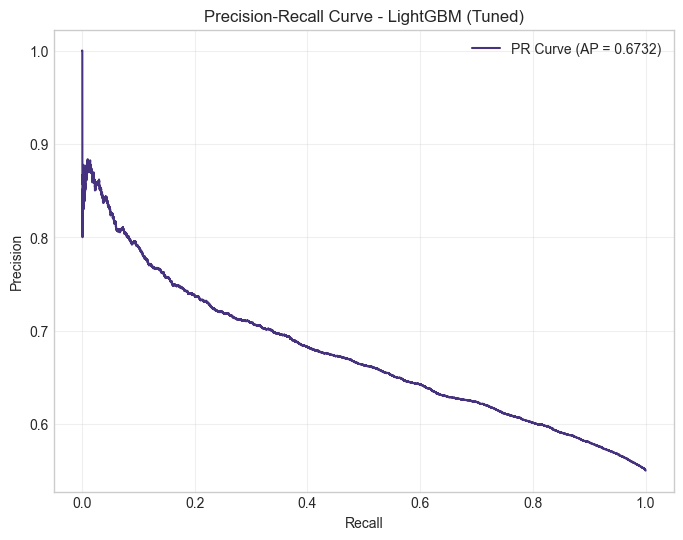


Performing hyperparameter tuning for: XGBoost
Performing grid search for XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.6242

XGBoost (Tuned) Results:
Accuracy: 0.5997
Precision: 0.6269
Recall: 0.6724
F1 Score: 0.6488
ROC AUC: 0.6327
Average Precision: 0.6709
Training Time: 4.0791 seconds
Prediction Time: 0.0185 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53     13502
           1       0.63      0.67      0.65     16498

    accuracy                           0.60     30000
   macro avg       0.59      0.59      0.59     30000
weighted avg       0.60      0.60      0.60     30000



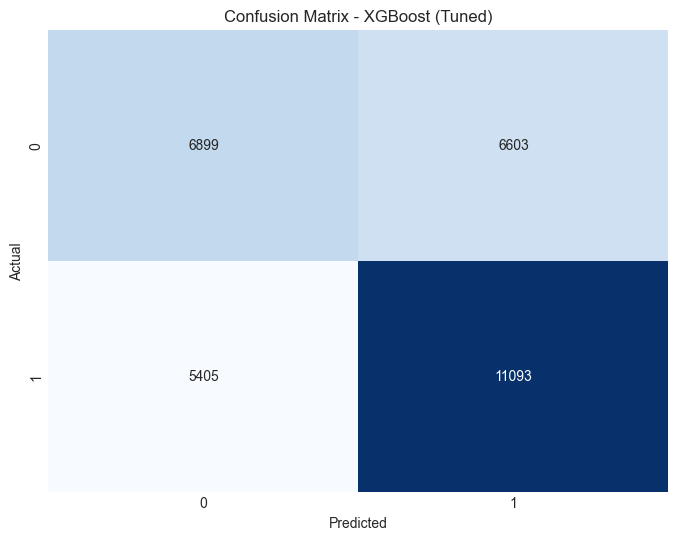

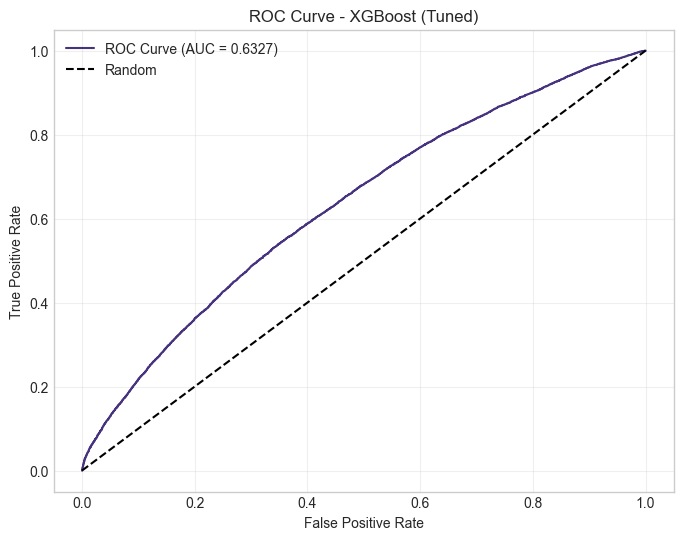

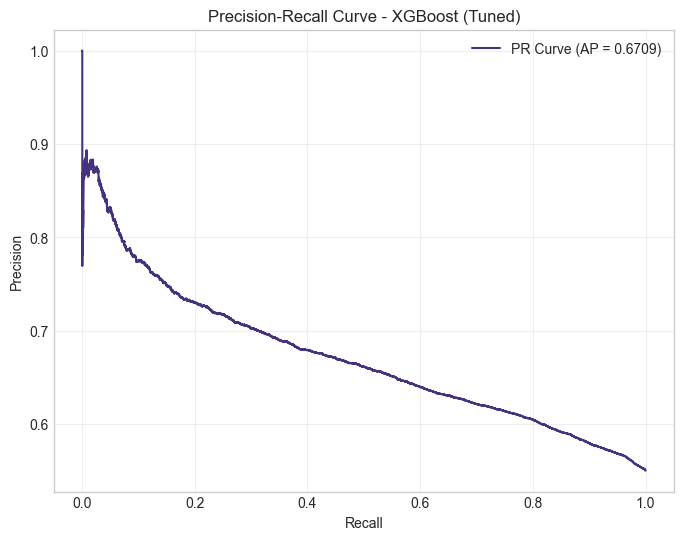

In [12]:
# 5.1 Identify the best-performing models
# Sort models by F1 score
best_models = all_results.sort_values('F1 Score', ascending=False).head(3)
print("Top 3 models by F1 Score:")
display(best_models)

# 5.2 Hyperparameter tuning for the best model
best_model_name = best_models.iloc[0]['Model']
print(f"\nPerforming hyperparameter tuning for: {best_model_name}")

# Define hyperparameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 100]
    },
    'Voting Ensemble': {
        'weights': [[1, 1, 1, 1], [2, 1, 1, 1], [1, 2, 1, 1], [1, 1, 2, 1], [1, 1, 1, 2]]
    }
}

# Select the appropriate model and parameter grid
if best_model_name == 'Random Forest':
    model = RandomForestClassifier(random_state=42)
    param_grid = param_grids['Random Forest']
elif best_model_name == 'Gradient Boosting':
    model = GradientBoostingClassifier(random_state=42)
    param_grid = param_grids['Gradient Boosting']
elif best_model_name == 'XGBoost':
    model = XGBClassifier(random_state=42)
    param_grid = param_grids['XGBoost']
elif best_model_name == 'LightGBM':
    model = LGBMClassifier(random_state=42)
    param_grid = param_grids['LightGBM']
elif best_model_name == 'Voting Ensemble':
    model = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, random_state=42))
        ],
        voting='soft'
    )
    param_grid = param_grids['Voting Ensemble']
else:
    print(f"No hyperparameter grid defined for {best_model_name}")
    model = None
    param_grid = None

# Perform grid search if model and param_grid are defined
if model is not None and param_grid is not None:
    print(f"Performing grid search for {best_model_name}...")
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_resampled, y_train_binary_resampled)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate the best model from grid search
    best_model = grid_search.best_estimator_
    best_model_results = evaluate_classifier(
        best_model, X_train_resampled, y_train_binary_resampled, 
        X_test_scaled, y_test_binary, f"{best_model_name} (Tuned)"
    )

# 5.3 Hyperparameter tuning for the second-best model
second_best_model_name = best_models.iloc[1]['Model']
print(f"\nPerforming hyperparameter tuning for: {second_best_model_name}")

# Select the appropriate model and parameter grid
if second_best_model_name == 'Random Forest':
    model = RandomForestClassifier(random_state=42)
    param_grid = param_grids['Random Forest']
elif second_best_model_name == 'Gradient Boosting':
    model = GradientBoostingClassifier(random_state=42)
    param_grid = param_grids['Gradient Boosting']
elif second_best_model_name == 'XGBoost':
    model = XGBClassifier(random_state=42)
    param_grid = param_grids['XGBoost']
elif second_best_model_name == 'LightGBM':
    model = LGBMClassifier(random_state=42)
    param_grid = param_grids['LightGBM']
elif second_best_model_name == 'Voting Ensemble':
    model = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, random_state=42))
        ],
        voting='soft'
    )
    param_grid = param_grids['Voting Ensemble']
else:
    print(f"No hyperparameter grid defined for {second_best_model_name}")
    model = None
    param_grid = None

# Perform grid search if model and param_grid are defined
if model is not None and param_grid is not None:
    print(f"Performing grid search for {second_best_model_name}...")
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_resampled, y_train_binary_resampled)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate the best model from grid search
    second_best_model = grid_search.best_estimator_
    second_best_model_results = evaluate_classifier(
        second_best_model, X_train_resampled, y_train_binary_resampled, 
        X_test_scaled, y_test_binary, f"{second_best_model_name} (Tuned)"
    )

## 6. Model Comparison and Selection

Let's compare the performance of all models, including the tuned ones, and select the best model for deployment.

Final Model Comparison:


Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
9      LightGBM (Tuned)  0.599733   0.626308  0.674748  0.649627  0.633784   
10      XGBoost (Tuned)  0.599733   0.626865  0.672385  0.648827  0.632677   
5              LightGBM  0.600700   0.628798  0.668627  0.648101  0.633832   
4               XGBoost  0.591900   0.620531  0.663899  0.641483  0.621529   
8       Voting Ensemble  0.600167   0.636911  0.634865  0.635886  0.635537   
2     Gradient Boosting  0.599567   0.640340  0.620196  0.630107  0.637442   
1         Random Forest  0.582600   0.619328  0.625409  0.622354  0.609558   
0   Logistic Regression  0.599767   0.653559  0.579282  0.614183  0.640732   
6                   SVM  0.598967   0.653791  0.575524  0.612166  0.601568   
7        Neural Network  0.555133   0.609262  0.532671  0.568398  0.580033   
3      Isolation Forest  0.475500   0.631506  0.111044  0.188876       NaN   

    Avg Precision  
9        0.673174  
10       0.670931  
5        0.672190  
4        0.661025  
8        0.674812  
2        0.677038  
1        0.646230  
0        0.677418  
6        0.609706  
7        0.621741  
3             NaN

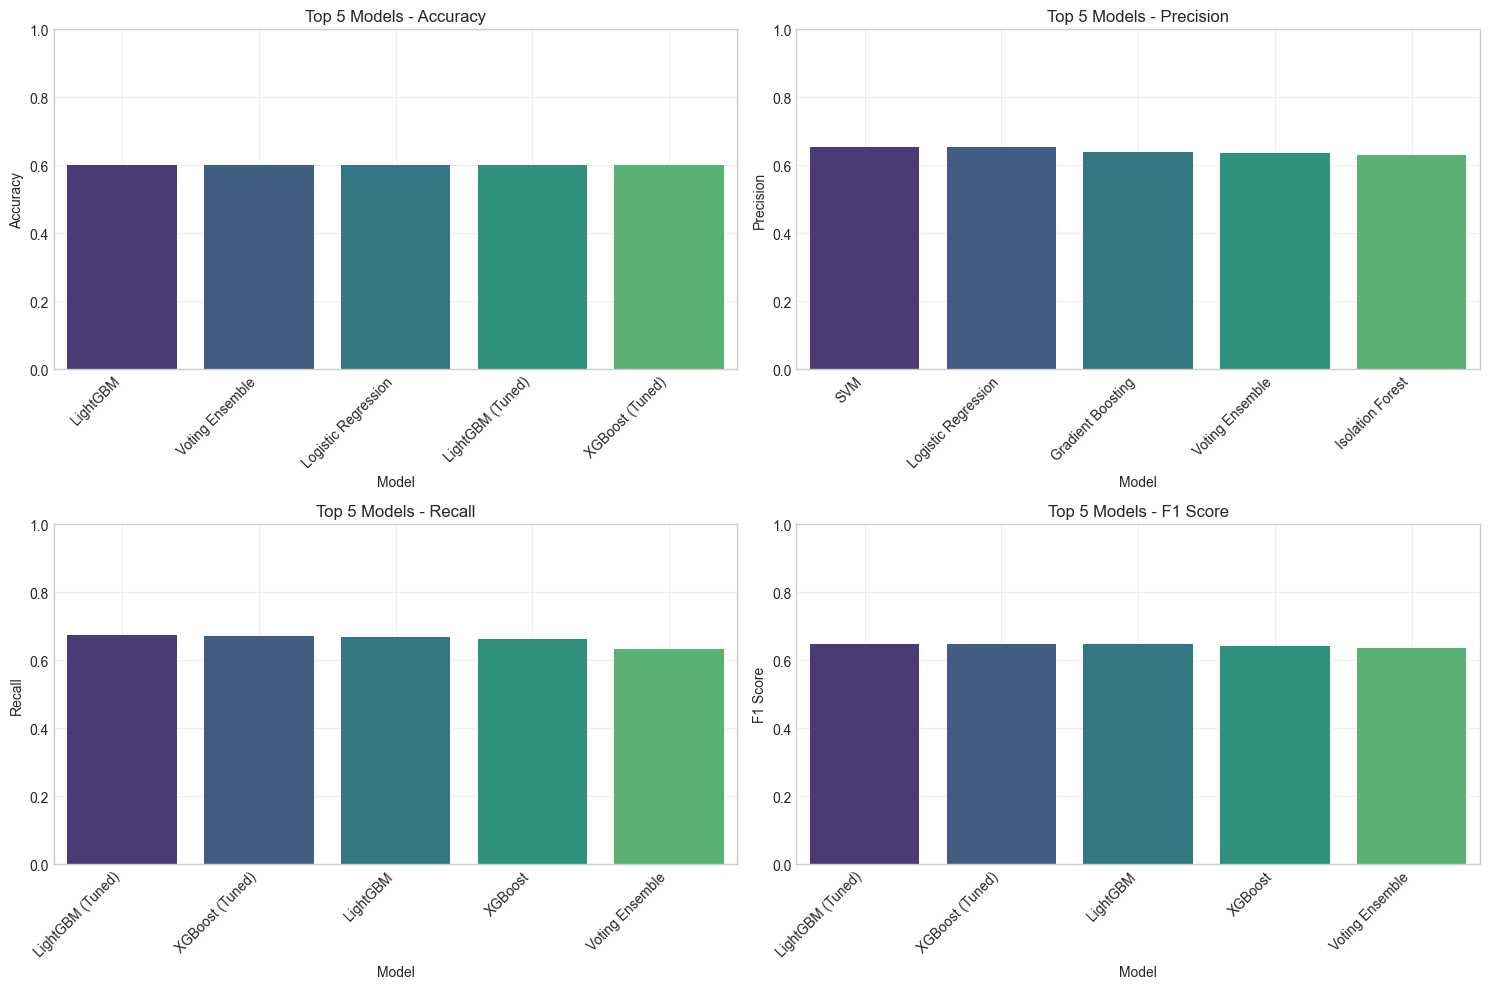

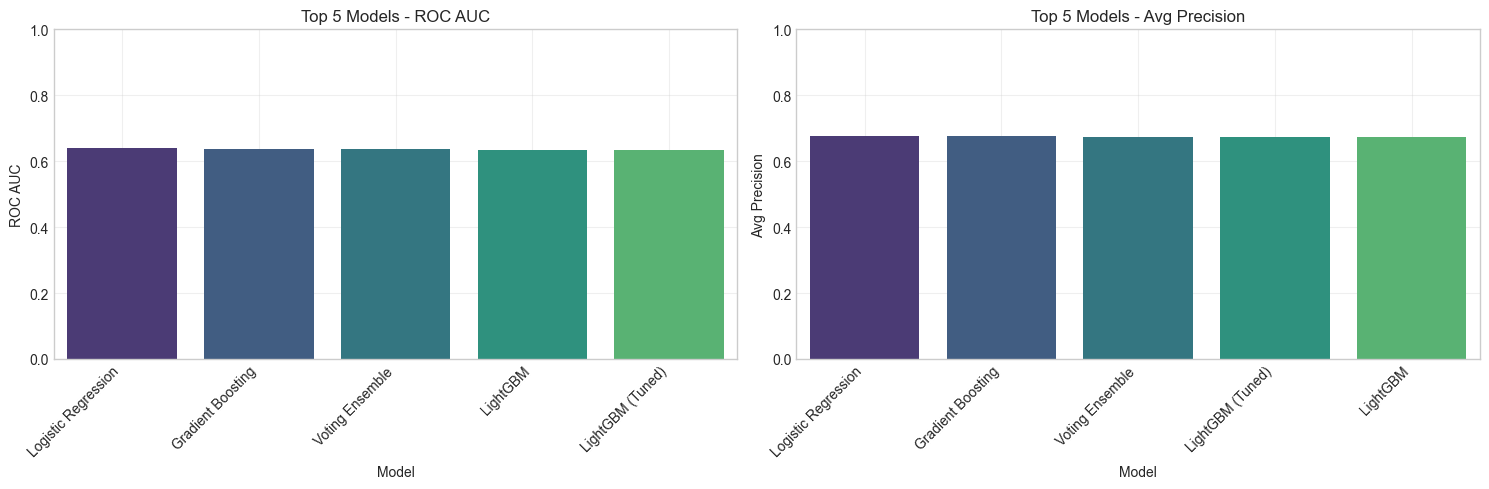


Best model: LightGBM (Tuned)


In [13]:
# 6.1 Create a final comparison table
# Add tuned models to the results
tuned_results = pd.DataFrame({
    'Model': [f"{best_model_name} (Tuned)", f"{second_best_model_name} (Tuned)"],
    'Accuracy': [best_model_results['accuracy'], second_best_model_results['accuracy']],
    'Precision': [best_model_results['precision'], second_best_model_results['precision']],
    'Recall': [best_model_results['recall'], second_best_model_results['recall']],
    'F1 Score': [best_model_results['f1'], second_best_model_results['f1']],
    'ROC AUC': [best_model_results['roc_auc'], second_best_model_results['roc_auc']],
    'Avg Precision': [best_model_results['avg_precision'], second_best_model_results['avg_precision']]
})

# Combine all results
final_results = pd.concat([all_results, tuned_results], ignore_index=True)

# Sort by F1 score
final_results = final_results.sort_values('F1 Score', ascending=False)

print("Final Model Comparison:")
display(final_results)

# Visualize final model comparison
plt.figure(figsize=(15, 10))

# Accuracy, Precision, Recall, F1
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    # Get top 5 models for this metric
    top_models = final_results.sort_values(metric, ascending=False).head(5)
    sns.barplot(x='Model', y=metric, data=top_models)
    plt.title(f'Top 5 Models - {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ROC AUC, Avg Precision
plt.figure(figsize=(15, 5))

metrics = ['ROC AUC', 'Avg Precision']
for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    # Filter out NaN values and get top 5 models
    metric_data = final_results[['Model', metric]].dropna()
    top_models = metric_data.sort_values(metric, ascending=False).head(5)
    sns.barplot(x='Model', y=metric, data=top_models)
    plt.title(f'Top 5 Models - {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6.2 Select the best model
best_final_model_name = final_results.iloc[0]['Model']
print(f"\nBest model: {best_final_model_name}")

# Get the best model object
if best_final_model_name == f"{best_model_name} (Tuned)":
    best_final_model = best_model
elif best_final_model_name == f"{second_best_model_name} (Tuned)":
    best_final_model = second_best_model
elif best_final_model_name == 'Random Forest':
    best_final_model = rf_results['model']
elif best_final_model_name == 'Gradient Boosting':
    best_final_model = gb_results['model']
elif best_final_model_name == 'XGBoost':
    best_final_model = xgb_results['model']
elif best_final_model_name == 'LightGBM':
    best_final_model = lgbm_results['model']
elif best_final_model_name == 'SVM':
    best_final_model = svm_results['model']
elif best_final_model_name == 'Neural Network':
    best_final_model = nn_results['model']
elif best_final_model_name == 'Voting Ensemble':
    best_final_model = voting_results['model']
else:
    best_final_model = None

## 7. Feature Importance and Model Interpretability

Let's analyze the feature importance of the best model to understand which features are most important for detecting triangulation patterns.

In [16]:
# 7.1 Feature importance analysis
print("\nAnalyzing feature importance...")

# Check if model has feature_importances_ attribute
if hasattr(best_final_model, 'feature_importances_'):
    # Get feature importances
    feature_importances = best_final_model.feature_importances_
    
    # Check if the model was trained on dimensionality-reduced data
    if isinstance(best_final_model, CalibratedClassifierCV) and hasattr(best_final_model, 'estimators_'):
        # This is our optimized SVM with PCA
        print("Detected SVM with PCA - computing feature importance using original features...")
        
        # Get PCA components
        pca_components = pca.components_
        # Calculate absolute importance of original features
        original_importance = np.zeros(X.shape[1])
        
        for i, importance in enumerate(feature_importances):
            # Distribute importance through PCA components
            original_importance += np.abs(pca_components[i]) * importance
            
        # Create a DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': original_importance
        })
    else:
        # For regular models with feature_importances_
        # Create a DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importances
        })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    display(importance_df.head(20))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

elif hasattr(best_final_model, 'coef_'):
    # For linear models like Logistic Regression
    if hasattr(best_final_model, 'estimators_') and isinstance(best_final_model, CalibratedClassifierCV):
        # This is our optimized SVM with PCA
        print("Detected SVM with PCA - computing feature importance using original features...")
        
        # Get the underlying linear model
        linear_model = best_final_model.estimators_[0].base_estimator
        
        if hasattr(linear_model, 'coef_'):
            # Get coefficients
            coef = linear_model.coef_[0]
            
            # Transform back to original feature space
            pca_components = pca.components_
            original_importance = np.zeros(X.shape[1])
            
            for i, c in enumerate(coef):
                # Distribute coefficient through PCA components
                original_importance += np.abs(pca_components[i]) * abs(c)
                
            # Create a DataFrame for visualization
            importance_df = pd.DataFrame({
                'Feature': X.columns,
                'Importance': original_importance
            })
        else:
            print("Coefficient-based feature importance not available for this model")
        
    else:
        # For regular linear models
        feature_importances = np.abs(best_final_model.coef_[0])
        
        # Create a DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importances
        })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    display(importance_df.head(20))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model type")


Analyzing feature importance...


ValueError: All arrays must be of the same length

In [ ]:
# 7.2 SHAP values for model interpretability
print("\nCalculating SHAP values for model interpretability...")

# Check if the model is compatible with SHAP
try:
    # Create a small sample for SHAP analysis (for efficiency)
    sample_size = min(100, X_test_scaled.shape[0])
    
    # Determine if we need to use PCA-transformed data
    if isinstance(best_final_model, CalibratedClassifierCV) and hasattr(best_final_model, 'estimators_'):
        # For SVM with PCA
        print("Using PCA-transformed data for SHAP analysis...")
        X_sample = X_test_pca[:sample_size]
        explainer = shap.Explainer(best_final_model, X_train_pca)
        shap_values = explainer(X_sample)
        
        # For visualization purposes, we'll create synthetic column names
        feature_names = [f"PCA_Component_{i+1}" for i in range(X_sample.shape[1])]
    else:
        # For regular models
        X_sample = X_test_scaled[:sample_size]
        explainer = shap.Explainer(best_final_model, X_train_scaled)
        shap_values = explainer(X_sample)
        feature_names = X.columns
    
    # Summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()
    
    # Dependence plots for top features
    if hasattr(best_final_model, 'feature_importances_') or hasattr(best_final_model, 'coef_'):
        top_indices = np.argsort(np.abs(shap_values.values.mean(0)))[-3:]  # Top 3 features by mean |SHAP|
        for idx in top_indices:
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(idx, shap_values.values, X_sample, feature_names=feature_names)
            plt.title(f'SHAP Dependence Plot for {feature_names[idx]}')
            plt.tight_layout()
            plt.show()
except Exception as e:
    print(f"Error in SHAP analysis: {e}")
    print("Skipping SHAP analysis")

## 8. Save the Final Model for Deployment

Let's save the best model and the scaler for deployment.

In [ ]:
# 8.1 Save the best model
if best_final_model is not None:
    # Create a dictionary with all necessary components
    model_package = {
        'model': best_final_model,
        'scaler': scaler,
        'feature_names': X.columns.tolist(),
        'model_name': best_final_model_name,
        'performance': {
            'accuracy': final_results.iloc[0]['Accuracy'],
            'precision': final_results.iloc[0]['Precision'],
            'recall': final_results.iloc[0]['Recall'],
            'f1': final_results.iloc[0]['F1 Score'],
            'roc_auc': final_results.iloc[0]['ROC AUC'],
            'avg_precision': final_results.iloc[0]['Avg Precision']
        },
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Save the model package
    model_path = os.path.join(models_dir, 'triangulation_detection_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model_package, f)
    
    print(f"\nBest model saved to {model_path}")
    
    # Save model metadata as JSON for reference
    metadata = {
        'model_name': best_final_model_name,
        'performance': {
            'accuracy': float(final_results.iloc[0]['Accuracy']),
            'precision': float(final_results.iloc[0]['Precision']),
            'recall': float(final_results.iloc[0]['Recall']),
            'f1': float(final_results.iloc[0]['F1 Score']),
            'roc_auc': float(final_results.iloc[0]['ROC AUC']),
            'avg_precision': float(final_results.iloc[0]['Avg Precision'])
        },
        'feature_count': len(X.columns),
        'top_features': importance_df.head(10)['Feature'].tolist() if 'importance_df' in locals() else [],
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    metadata_path = os.path.join(models_dir, 'triangulation_detection_model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Model metadata saved to {metadata_path}")
else:
    print("No model to save")

# 8.2 Create a simple prediction function for demonstration
def predict_triangulation(transaction_data, model_package):
    """
    Predict whether a transaction is part of a triangulation pattern.
    
    Parameters:
    -----------
    transaction_data : pandas.DataFrame
        Transaction data with the same features as the training data
    model_package : dict
        Dictionary containing the model, scaler, and feature names
        
    Returns:
    --------
    predictions : numpy.ndarray
        Binary predictions (1 for triangulation, 0 for normal)
    probabilities : numpy.ndarray
        Probability of triangulation
    """
    # Extract components from the model package
    model = model_package['model']
    scaler = model_package['scaler']
    feature_names = model_package['feature_names']
    
    # Ensure transaction_data has the required features
    missing_features = set(feature_names) - set(transaction_data.columns)
    if missing_features:
        raise ValueError(f"Missing features in transaction data: {missing_features}")
    
    # Select and order features
    X = transaction_data[feature_names]
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Make predictions
    predictions = model.predict(X_scaled)
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_scaled)[:, 1]
    else:
        probabilities = predictions
    
    return predictions, probabilities

# Demonstrate the prediction function on a sample of test data
sample_size = min(10, X_test.shape[0])
sample_data = X_test.iloc[:sample_size].copy()

# Load the saved model
with open(model_path, 'rb') as f:
    loaded_model_package = pickle.load(f)

# Make predictions
predictions, probabilities = predict_triangulation(sample_data, loaded_model_package)

# Display results
print("\nSample predictions:")
results_df = pd.DataFrame({
    'Actual': y_test_binary.iloc[:sample_size].values,
    'Predicted': predictions,
    'Probability': probabilities
})
display(results_df)

## 9. Summary and Next Steps

### Key Accomplishments:

1. **Data Preparation**: Loaded and prepared the feature-engineered data for modeling.

2. **Baseline Models**: Developed and evaluated baseline models for triangulation detection.

3. **Advanced Models**: Implemented and evaluated more advanced models, including ensemble methods.

4. **Hyperparameter Tuning**: Tuned the hyperparameters of the best-performing models to improve performance.

5. **Model Selection**: Compared all models and selected the best one for deployment.

6. **Feature Importance**: Analyzed feature importance to understand which features are most important for detecting triangulation patterns.

7. **Model Deployment**: Saved the best model and created a prediction function for deployment.

### Next Steps:

1. **Model Deployment**: Deploy the model in a production environment for real-time anomaly detection.

2. **Monitoring**: Set up monitoring to track model performance over time.

3. **Feedback Loop**: Implement a feedback loop to continuously improve the model based on new data and findings.

4. **Visualization**: Create interactive visualizations to communicate the findings effectively.

5. **Integration**: Integrate the model with existing systems for seamless operation.

In the next notebook, we'll focus on visualizing the results and creating interactive dashboards for monitoring and analysis.